# Условие

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:
- [X] Выведите кол-во обучаемых параметров сети;    
- [X] Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.
- [X] Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
- [ ] Выведите confusion matrix для тестовой подвыборки;    

# Особенности

У меня все выполнялось на cpu, разрешили взять половину

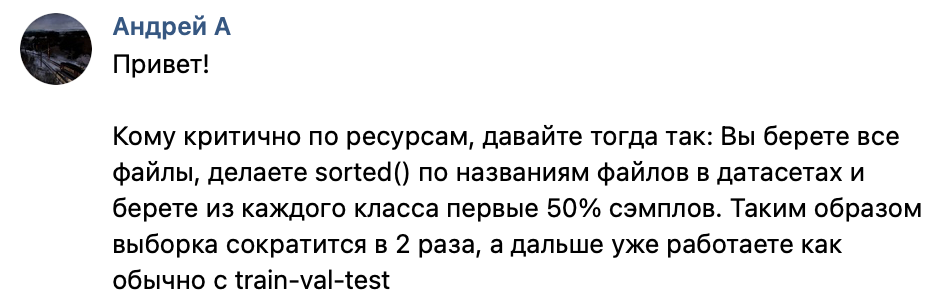


# Домашняя работа

## Подключаем билиотеки и константы

In [1]:
!pip install torchmetrics numpy torch matplotlib torchvision tqdm progressbar

In [2]:
import os
import warnings
import time
import progressbar

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import layers as l # Results from hw1 + hw2

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import no_grad, max, device, cuda
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import f1_score   

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
DEVICE = device("cuda:0" if cuda.is_available() else "cpu")
print(DEVICE)

cpu


## Подгрузка данных

In [55]:
SHAPE = 256
data_dir = './indoor_outdoor_dataset/'

# В идеале надо бы еще шум наложить, но я ограничен технически
transform = transforms.Compose([
    transforms.Resize([SHAPE, SHAPE]),
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

full_data = ImageFolder(data_dir, transform=transform)

train_size = int(0.015625 * len(full_data)) # Половина для обучения
test_size = int(0.001 * len(full_data))
del_size = len(full_data) - train_size - test_size
print(f'train_size = {train_size}\ntest_size = {test_size}\nnot_use = {del_size}')

train_data, test_data, _ = random_split(full_data, [train_size, test_size, del_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

train_size = 6414
test_size = 410
not_use = 403700


In [5]:
LEARNING_RATE = 0.01
EPOCH = 10

In [6]:
def plot(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train', linewidth=1.0)
    plt.plot(test_loss_epochs, label='Test', linewidth=1.0)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train', linewidth=1.0)
    plt.plot(test_accuracy_epochs, label='Test', linewidth=1.0)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [7]:
def plotLAF(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs,
            train_f1_epochs, test_f1_epochs, epochs=20):
    train = [ train_loss_epochs, train_accuracy_epochs, train_f1_epochs ]
    test = [ test_loss_epochs, test_accuracy_epochs, test_f1_epochs ]
    label = [ 'Loss', 'Accuracy', 'F1' ]
    plt.figure(figsize=(12.5, 4))
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.plot(train[(i - 1)], label='Train', linewidth=1.0)
        plt.plot(test[(i - 1)], label='Test', linewidth=1.0)
        plt.xlabel('Epochs')
        plt.ylabel(label[(i - 1)])
        plt.ylim([0, 1])
        plt.xlim([0, epochs])
        plt.legend(loc=0)
        plt.grid()
    plt.show()

## Модель на основе семинара 1 и 2

Решил написать модель на основе кода семинара 1 и 2. Но обучение было каким-то долгим и разрешили использовать модули из nn. Важное уточнение в начале для этого надо было конвертировать в серый цвет. Признал этот вариант тупиковым, так как:
1) Только в сером цвете происходит свертка, возможно информация из цветов теряется;
2) Надо было самому реализовать остальные возможности tourch
3) По моим ощущениям где-то внутри возникает bottle-neck

In [144]:
def train(network, epochs, learning_rate, loss=None):    
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    for epoch in range(epochs):
        start_time = time.time()
        losses = []
        accuracies = []
        for X, y in train_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
    
            prediction = network.forward(X)
            loss_batch = loss.forward(prediction, y)
            losses.append(loss_batch)

            dLdx = loss.backward()
            network.backward(dLdx)
            network.step(learning_rate)
            accuracies.append((np.argmax(prediction, 1)==y).mean())
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        losses = []
        accuracies = []    
        for X, y in test_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
            prediction = network.forward(X)
            loss_batch = loss.forward(prediction, y)
            losses.append(loss_batch)
            accuracies.append((np.argmax(prediction, 1)==y).mean())
        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))
            
        print(
            '\rEpoch [{0}/{1}] (Train/Test) NLL: {2:.3f}/{3:.3f}, Accuracy: {4:.3f}/{5:.3f} t: {6:.4f} s'.format(
                (epoch+1), epochs, train_loss_epochs[-1], test_loss_epochs[-1],
                train_accuracy_epochs[-1], test_accuracy_epochs[-1], (time.time() - start_time))
        )
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

Пример ниже прогонялся, пока эксперементировал. В начале были проблемы с обучением, был конфликт tourch+numpy. Решил позже, но уже решил не тратить время на переобучение модели, а перешел к следующему этапу

Epoch [1/20] (Train/Test) NLL: 0.648/0.000, Accuracy: 0.616/0.000 t: 8.5288 s
Epoch [2/20] (Train/Test) NLL: 0.620/0.000, Accuracy: 0.642/0.000 t: 8.5290 s
Epoch [3/20] (Train/Test) NLL: 0.600/0.000, Accuracy: 0.661/0.000 t: 8.6653 s
Epoch [4/20] (Train/Test) NLL: 0.577/0.000, Accuracy: 0.683/0.000 t: 8.6433 s
Epoch [5/20] (Train/Test) NLL: 0.552/0.000, Accuracy: 0.711/0.000 t: 8.6393 s
Epoch [6/20] (Train/Test) NLL: 0.521/0.000, Accuracy: 0.738/0.000 t: 8.7035 s
Epoch [7/20] (Train/Test) NLL: 0.497/0.000, Accuracy: 0.762/0.000 t: 8.8199 s
Epoch [8/20] (Train/Test) NLL: 0.453/0.000, Accuracy: 0.802/0.000 t: 8.6505 s
Epoch [9/20] (Train/Test) NLL: 0.418/0.000, Accuracy: 0.828/0.000 t: 8.5216 s
Epoch [10/20] (Train/Test) NLL: 0.390/0.000, Accuracy: 0.843/0.000 t: 8.7403 s
Epoch [11/20] (Train/Test) NLL: 0.361/0.000, Accuracy: 0.861/0.000 t: 8.5234 s
Epoch [12/20] (Train/Test) NLL: 0.329/0.000, Accuracy: 0.883/0.000 t: 8.5698 s
Epoch [13/20] (Train/Test) NLL: 0.280/0.000, Accuracy: 0.904/

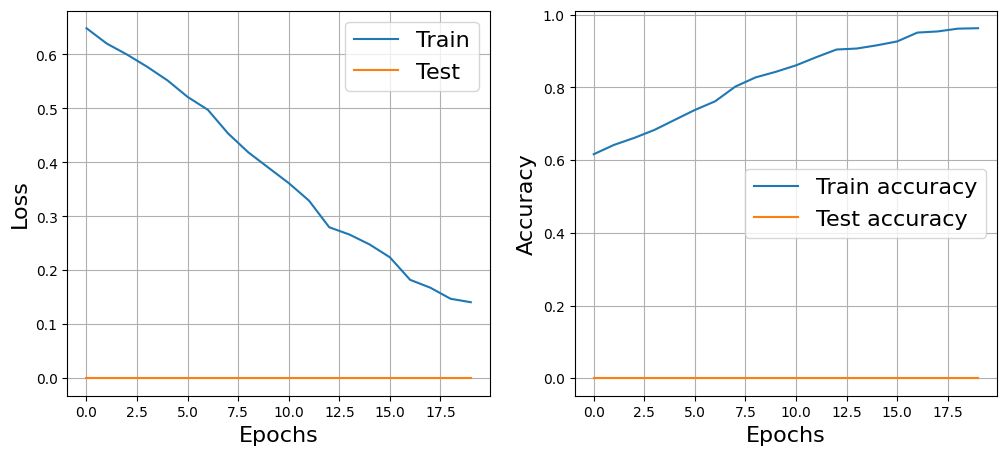

In [23]:
network = l.NeuralNetwork([
    l.Linear(SHAPE**2, 256), l.ReLU(),
    l.Linear(256, 2)
])
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, LEARNING_RATE, loss=l.NLLLoss())

## Модель с tourch

Для начала решил написать просто модель, чтобы прогнать тесты и посмотреть, что получается

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(SHAPE**2 , 512), nn.ReLU(),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 2), nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, SHAPE**2)
        x = self.fc_layers(x)
        return x

In [ ]:
device = DEVICE
model = Net().to(device)
print(model) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

print('Кол-во обучаемых параметров сети: ' + str(sum([p.numel() for p in model.parameters()])))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

In [ ]:
def train_tourch(model, criterion, optimizerm, epochs):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = []
        running_acc = []
        test_loss = []
        test_acc = []
    
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(accuracy(outputs, labels))
        train_loss_epochs.append(np.mean(running_loss))
        train_accuracy_epochs.append(np.mean(running_acc))

        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss.append(loss.item())
                test_acc.append(accuracy(outputs, labels))
        test_loss_epochs.append(np.mean(test_loss))
        test_accuracy_epochs.append(np.mean(test_acc))
            
        print(
            'Epoch [{0}/{1}] (Train/Test) NLL: {2:.3f}/{3:.3f}, Accuracy: {4:.3f}/{5:.3f} t: {6:.4f} s'.format(
            (epoch+1), (epochs), train_loss_epochs[-1], test_loss_epochs[-1], train_accuracy_epochs[-1],
            test_accuracy_epochs[-1], (time.time() - start_time))
        )
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

Важное уточнение в данном запуске был очень малый датасет

Epoch [1/20] (Train/Test) NLL: 0.642/0.627, Accuracy: 0.634/0.660 t: 219.2541 s
Epoch [2/20] (Train/Test) NLL: 0.611/0.610, Accuracy: 0.676/0.676 t: 201.2654 s
Epoch [3/20] (Train/Test) NLL: 0.594/0.603, Accuracy: 0.697/0.687 t: 207.3005 s
Epoch [4/20] (Train/Test) NLL: 0.583/0.597, Accuracy: 0.713/0.691 t: 201.8410 s
Epoch [5/20] (Train/Test) NLL: 0.573/0.594, Accuracy: 0.724/0.695 t: 201.9470 s
Epoch [6/20] (Train/Test) NLL: 0.564/0.593, Accuracy: 0.733/0.704 t: 202.4119 s
Epoch [7/20] (Train/Test) NLL: 0.556/0.586, Accuracy: 0.746/0.708 t: 202.8821 s
Epoch [8/20] (Train/Test) NLL: 0.548/0.592, Accuracy: 0.756/0.701 t: 202.3330 s
Epoch [9/20] (Train/Test) NLL: 0.539/0.585, Accuracy: 0.765/0.709 t: 200.2584 s
Epoch [10/20] (Train/Test) NLL: 0.532/0.595, Accuracy: 0.773/0.697 t: 200.1841 s
Epoch [11/20] (Train/Test) NLL: 0.525/0.591, Accuracy: 0.782/0.703 t: 193.7212 s
Epoch [12/20] (Train/Test) NLL: 0.518/0.590, Accuracy: 0.789/0.707 t: 194.1053 s
Epoch [13/20] (Train/Test) NLL: 0.511

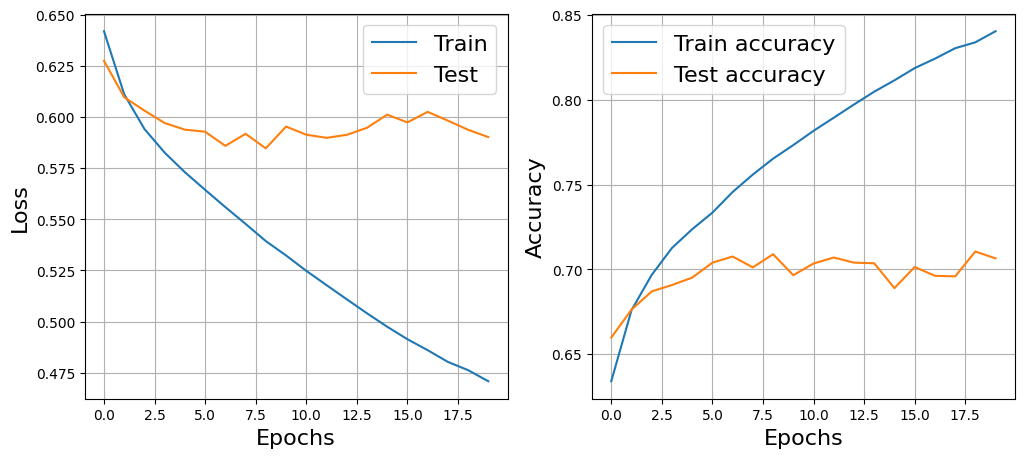

In [155]:
tr_r, ts_r, tr_ac_r, ts_ac_r = train_tourch(model, criterion, optimizer, 20)
plot(tr_r, ts_r, tr_ac_r, ts_ac_r)

### Калибровка

Переписал чтобы все было в класс

In [51]:
class Model:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self._f1_score = BinaryF1Score()

    def _accuracy(self, outputs, labels):
        self._pred = (outputs > 0.5).float()
        return torch.sum(self._pred == labels).item() / len(labels)

    def _f1(self, labels):
        return self._f1_score(self._pred, labels)
    
    def train(self, train_loader, test_loader, epochs, accurate_break=0.951):
        train_loss_epochs, train_accuracy_epochs, train_f1_epochs = [], [], []
        test_loss_epochs, test_accuracy_epochs, test_f1_epochs = [], [], []

        for epoch in tqdm(range(epochs)):
            start_time = time.time()
            running_loss, running_acc, running_f1 = [], [], []
            test_loss, test_acc, test_f1 = [], [], []

            # Обучение
            self.model.train()
            for i, (inputs, labels) in enumerate(train_loader):
                labels = labels.float()

                self.optimizer.zero_grad()
                outputs = self.model(inputs).view(-1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss.append(loss.item())
                running_acc.append(self._accuracy(outputs, labels))
                running_f1.append(self._f1(labels))

            train_loss_epochs.append(np.mean(running_loss))
            train_accuracy_epochs.append(np.mean(running_acc))
            train_f1_epochs.append(np.mean(running_f1))

            # Прогон по тестовой выборке
            self.model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    labels = labels.float()

                    outputs = self.model(inputs).view(-1)
                    loss = self.criterion(outputs, labels)

                    test_loss.append(loss.item())
                    test_acc.append(self._accuracy(outputs, labels))
                    test_f1.append(self._f1(labels))

            test_loss_epochs.append(np.mean(test_loss))
            test_accuracy_epochs.append(np.mean(test_acc))
            test_f1_epochs.append(np.mean(test_f1))
        
            print(
                f'Epoch [{(epoch+1)}/{epochs}] (Train/Test) ',
                f'Loss: {train_loss_epochs[-1]:.3f}/{test_loss_epochs[-1]:.3f}, ',
                f'Accuracy: {train_accuracy_epochs[-1]:.3f}/{test_accuracy_epochs[-1]:.3f}, ',
                f'F1: {train_f1_epochs[-1]:.3f}/{test_f1_epochs[-1]:.3f}, ',
                f't: {(time.time() - start_time):.3f} s'
            )

            if train_accuracy_epochs[-1] >= accurate_break and test_accuracy_epochs[-1] >= accurate_break:
                print('На обучающей и тестовой выборке достигли желаемого результата.\n',
                      'Чтобы не израходовать ресурсы машины:\t break')
                break

        plotLAF(
            train_loss_epochs, test_loss_epochs,
            train_accuracy_epochs, test_accuracy_epochs,
            train_f1_epochs, test_f1_epochs
        )
        return train_loss_epochs, test_loss_epochs, \
               train_accuracy_epochs, test_accuracy_epochs, \
               train_f1_epochs, test_f1_epochs

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return outputs

In [52]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), # 256x256x32
            nn.MaxPool2d(kernel_size=2, stride=2),                 # 128x128x32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), # 128x128x64
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 64x64x64
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), # 64x64x128
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 32x32x128
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), # 32x32x256
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 16x16x256
            
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512), nn.ReLU(),
            nn.Linear(512, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [53]:
device = DEVICE
cnn = CNN().to(device)
print(cnn) 

criterion = nn.BCELoss()
optimizer = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)

print('Кол-во обучаемых параметров сети: ' + str(sum([p.numel() for p in cnn.parameters()])))

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=65536, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=True)
    (16): Sigmoid()
  )
)
Кол-во обучаемых параметров сети: 33943873


In [31]:
torch.get_num_threads()

6

Увеличим кол-во ядер

In [32]:
torch.set_num_threads(7)

In [33]:
torch.get_num_threads()

7

Руками прервал, на 13% от истинных размерах датасета нужно было ждать ~ 25 часов, чтобы обучился, я решил еще сильнее уменьшить размер

Ошибка возникла из за ручного прерывания процесса

In [39]:
%%time
model = Model(cnn, criterion, optimizer)
tr_r, ts_r, tr_ac_r, ts_ac_r, tr_f1_r, ts_f1_r = model.train(train_loader, test_loader, 40)

  2%|▉                                      | 1/40 [36:59<24:02:35, 2219.37s/it]

Epoch [1/40] (Train/Test)  Loss: 0.531/0.439,  Accuracy: 0.726/0.799,  F1: 0.649/0.773,  t: 2219.375 s


  2%|▉                                      | 1/40 [50:32<32:51:17, 3032.74s/it]


KeyboardInterrupt: 

В данный момент данных ~< 7 % от всего объема, время обучения займет ~ 12 ч. Я решил, что это тоже слишком долго, и еще уменьшил размер

Ниже блок выполнялся на *уменьшенной* выборке

  2%|█                                        | 1/40 [04:52<3:09:50, 292.07s/it]

Epoch [1/40] (Train/Test)  Loss: 0.685/0.669,  Accuracy: 0.570/0.642,  F1: 0.297/0.495,  t: 292.073 s


  5%|██                                       | 2/40 [09:57<3:09:52, 299.81s/it]

Epoch [2/40] (Train/Test)  Loss: 0.642/0.585,  Accuracy: 0.639/0.684,  F1: 0.548/0.678,  t: 305.227 s


  8%|███                                      | 3/40 [15:04<3:06:56, 303.15s/it]

Epoch [3/40] (Train/Test)  Loss: 0.564/0.506,  Accuracy: 0.711/0.740,  F1: 0.657/0.722,  t: 307.126 s


 10%|████                                     | 4/40 [20:13<3:03:24, 305.68s/it]

Epoch [4/40] (Train/Test)  Loss: 0.520/0.573,  Accuracy: 0.743/0.690,  F1: 0.702/0.549,  t: 309.560 s


 12%|█████▏                                   | 5/40 [25:21<2:58:47, 306.49s/it]

Epoch [5/40] (Train/Test)  Loss: 0.503/0.460,  Accuracy: 0.760/0.797,  F1: 0.723/0.763,  t: 307.933 s


 15%|██████▏                                  | 6/40 [30:33<2:54:44, 308.38s/it]

Epoch [6/40] (Train/Test)  Loss: 0.485/0.487,  Accuracy: 0.770/0.765,  F1: 0.741/0.686,  t: 312.041 s


 18%|███████▏                                 | 7/40 [35:40<2:49:17, 307.79s/it]

Epoch [7/40] (Train/Test)  Loss: 0.472/0.427,  Accuracy: 0.783/0.803,  F1: 0.752/0.768,  t: 306.570 s


 20%|████████▏                                | 8/40 [40:54<2:45:14, 309.84s/it]

Epoch [8/40] (Train/Test)  Loss: 0.455/0.404,  Accuracy: 0.797/0.802,  F1: 0.771/0.803,  t: 314.228 s


 22%|█████████▏                               | 9/40 [46:00<2:39:28, 308.67s/it]

Epoch [9/40] (Train/Test)  Loss: 0.441/0.581,  Accuracy: 0.798/0.690,  F1: 0.771/0.748,  t: 306.086 s


 25%|██████████                              | 10/40 [51:08<2:34:09, 308.32s/it]

Epoch [10/40] (Train/Test)  Loss: 0.428/0.375,  Accuracy: 0.813/0.843,  F1: 0.790/0.825,  t: 307.555 s


 28%|███████████                             | 11/40 [56:30<2:31:02, 312.51s/it]

Epoch [11/40] (Train/Test)  Loss: 0.414/0.366,  Accuracy: 0.818/0.826,  F1: 0.793/0.811,  t: 322.003 s


 30%|███████████▍                          | 12/40 [1:01:55<2:27:40, 316.45s/it]

Epoch [12/40] (Train/Test)  Loss: 0.406/0.365,  Accuracy: 0.821/0.842,  F1: 0.798/0.823,  t: 325.447 s


 32%|████████████▎                         | 13/40 [1:07:18<2:23:13, 318.27s/it]

Epoch [13/40] (Train/Test)  Loss: 0.398/0.428,  Accuracy: 0.824/0.788,  F1: 0.802/0.805,  t: 322.459 s


 35%|█████████████▎                        | 14/40 [1:12:40<2:18:25, 319.46s/it]

Epoch [14/40] (Train/Test)  Loss: 0.392/0.384,  Accuracy: 0.829/0.839,  F1: 0.808/0.805,  t: 322.215 s


 38%|██████████████▎                       | 15/40 [1:18:00<2:13:09, 319.59s/it]

Epoch [15/40] (Train/Test)  Loss: 0.378/0.372,  Accuracy: 0.840/0.834,  F1: 0.819/0.834,  t: 319.883 s


 40%|███████████████▏                      | 16/40 [1:23:22<2:08:05, 320.24s/it]

Epoch [16/40] (Train/Test)  Loss: 0.370/0.372,  Accuracy: 0.842/0.822,  F1: 0.820/0.831,  t: 321.746 s


 42%|████████████████▏                     | 17/40 [1:28:28<2:01:09, 316.07s/it]

Epoch [17/40] (Train/Test)  Loss: 0.366/0.633,  Accuracy: 0.844/0.687,  F1: 0.822/0.747,  t: 306.394 s


 45%|█████████████████                     | 18/40 [1:33:33<1:54:39, 312.72s/it]

Epoch [18/40] (Train/Test)  Loss: 0.361/0.421,  Accuracy: 0.846/0.780,  F1: 0.827/0.800,  t: 304.908 s


 48%|██████████████████                    | 19/40 [1:38:39<1:48:43, 310.62s/it]

Epoch [19/40] (Train/Test)  Loss: 0.356/0.346,  Accuracy: 0.847/0.854,  F1: 0.827/0.847,  t: 305.743 s


 50%|███████████████████                   | 20/40 [1:43:44<1:43:01, 309.07s/it]

Epoch [20/40] (Train/Test)  Loss: 0.352/0.385,  Accuracy: 0.852/0.837,  F1: 0.832/0.841,  t: 305.435 s


 52%|███████████████████▉                  | 21/40 [1:49:06<1:39:06, 312.95s/it]

Epoch [21/40] (Train/Test)  Loss: 0.339/0.429,  Accuracy: 0.858/0.808,  F1: 0.838/0.757,  t: 322.006 s


 55%|████████████████████▉                 | 22/40 [1:54:19<1:33:50, 312.82s/it]

Epoch [22/40] (Train/Test)  Loss: 0.332/0.401,  Accuracy: 0.860/0.828,  F1: 0.838/0.787,  t: 312.501 s


 57%|█████████████████████▊                | 23/40 [1:59:29<1:28:26, 312.17s/it]

Epoch [23/40] (Train/Test)  Loss: 0.323/0.398,  Accuracy: 0.868/0.815,  F1: 0.852/0.771,  t: 310.670 s


 60%|██████████████████████▊               | 24/40 [2:04:09<1:20:39, 302.47s/it]

Epoch [24/40] (Train/Test)  Loss: 0.318/0.384,  Accuracy: 0.867/0.817,  F1: 0.851/0.826,  t: 279.848 s


 62%|███████████████████████▊              | 25/40 [2:08:46<1:13:40, 294.70s/it]

Epoch [25/40] (Train/Test)  Loss: 0.309/0.514,  Accuracy: 0.870/0.732,  F1: 0.856/0.626,  t: 276.567 s


 65%|████████████████████████▋             | 26/40 [2:13:21<1:07:24, 288.93s/it]

Epoch [26/40] (Train/Test)  Loss: 0.297/0.341,  Accuracy: 0.877/0.854,  F1: 0.864/0.850,  t: 275.459 s


 68%|█████████████████████████▋            | 27/40 [2:17:56<1:01:40, 284.64s/it]

Epoch [27/40] (Train/Test)  Loss: 0.296/0.363,  Accuracy: 0.878/0.836,  F1: 0.865/0.840,  t: 274.622 s


 70%|████████████████████████████            | 28/40 [2:22:31<56:20, 281.72s/it]

Epoch [28/40] (Train/Test)  Loss: 0.281/0.406,  Accuracy: 0.884/0.837,  F1: 0.873/0.801,  t: 274.932 s


 72%|█████████████████████████████           | 29/40 [2:27:08<51:23, 280.33s/it]

Epoch [29/40] (Train/Test)  Loss: 0.267/0.549,  Accuracy: 0.892/0.779,  F1: 0.880/0.708,  t: 277.067 s


 75%|██████████████████████████████          | 30/40 [2:31:42<46:23, 278.38s/it]

Epoch [30/40] (Train/Test)  Loss: 0.261/0.465,  Accuracy: 0.896/0.805,  F1: 0.886/0.753,  t: 273.847 s


 78%|███████████████████████████████         | 31/40 [2:36:16<41:33, 277.07s/it]

Epoch [31/40] (Train/Test)  Loss: 0.244/0.384,  Accuracy: 0.904/0.815,  F1: 0.892/0.824,  t: 274.019 s


 80%|████████████████████████████████        | 32/40 [2:40:52<36:54, 276.81s/it]

Epoch [32/40] (Train/Test)  Loss: 0.235/0.354,  Accuracy: 0.905/0.863,  F1: 0.894/0.847,  t: 276.194 s


 82%|█████████████████████████████████       | 33/40 [2:45:26<32:12, 276.11s/it]

Epoch [33/40] (Train/Test)  Loss: 0.222/0.421,  Accuracy: 0.912/0.846,  F1: 0.904/0.816,  t: 274.473 s


 85%|██████████████████████████████████      | 34/40 [2:50:22<28:11, 281.86s/it]

Epoch [34/40] (Train/Test)  Loss: 0.210/0.337,  Accuracy: 0.915/0.868,  F1: 0.906/0.855,  t: 295.282 s


 88%|███████████████████████████████████     | 35/40 [2:55:29<24:06, 289.36s/it]

Epoch [35/40] (Train/Test)  Loss: 0.197/0.342,  Accuracy: 0.925/0.868,  F1: 0.917/0.861,  t: 306.863 s


 90%|████████████████████████████████████    | 36/40 [3:00:32<19:34, 293.66s/it]

Epoch [36/40] (Train/Test)  Loss: 0.182/0.529,  Accuracy: 0.928/0.794,  F1: 0.920/0.816,  t: 303.674 s


 92%|█████████████████████████████████████   | 37/40 [3:05:45<14:58, 299.38s/it]

Epoch [37/40] (Train/Test)  Loss: 0.167/0.387,  Accuracy: 0.936/0.824,  F1: 0.930/0.823,  t: 312.752 s


 95%|██████████████████████████████████████  | 38/40 [3:10:56<10:05, 302.91s/it]

Epoch [38/40] (Train/Test)  Loss: 0.150/0.387,  Accuracy: 0.944/0.864,  F1: 0.939/0.851,  t: 311.145 s


 98%|███████████████████████████████████████ | 39/40 [3:16:01<05:03, 303.44s/it]

Epoch [39/40] (Train/Test)  Loss: 0.133/0.394,  Accuracy: 0.952/0.854,  F1: 0.948/0.849,  t: 304.684 s


100%|████████████████████████████████████████| 40/40 [3:21:07<00:00, 301.69s/it]

Epoch [40/40] (Train/Test)  Loss: 0.125/0.396,  Accuracy: 0.959/0.848,  F1: 0.955/0.836,  t: 306.206 s


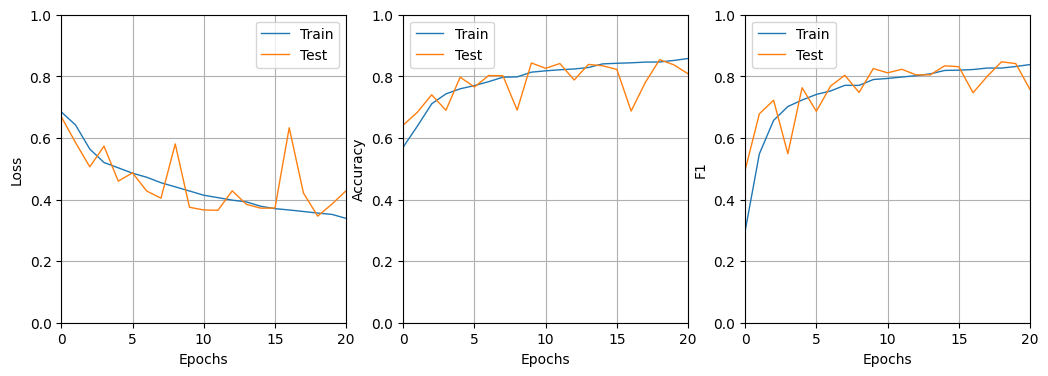

CPU times: user 14h 10min 35s, sys: 8h 11min 48s, total: 22h 22min 23s
Wall time: 3h 21min 7s


In [56]:
%%time
model = Model(cnn, criterion, optimizer)
tr_r, ts_r, tr_ac_r, ts_ac_r, tr_f1_r, ts_f1_r = model.train(train_loader, test_loader, 40)

В графике сверху забыл добавить параметр размера векторов, ниже на основе сохраненных данных.

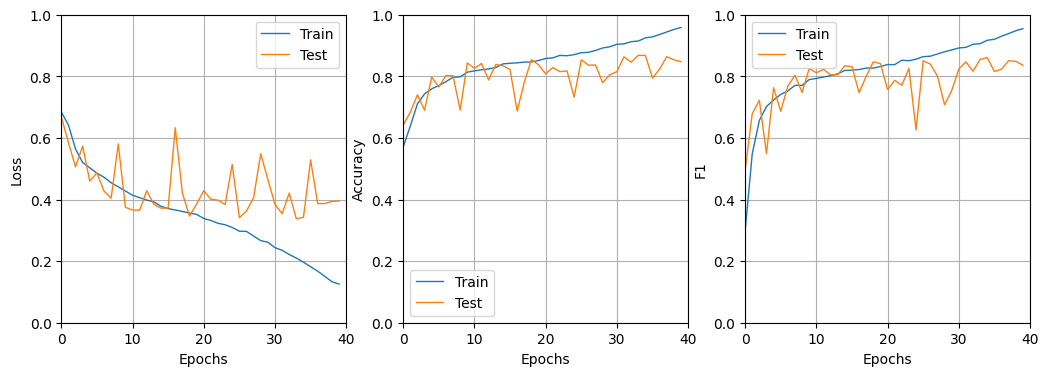

In [58]:
plotLAF(tr_r, ts_r, tr_ac_r, ts_ac_r, tr_f1_r, ts_f1_r, 40)

**Вывод:**
1) Оно же ключевое, Apple M1 не подходит для обучение нейро-сетей, даже если брать в расчет, что у меня не очень удачно подобраны слои/гиперпараметры/функция ошибки и т. д. - Я уверен, что если это все подобрать сильно быстрее работать не будет.

Теперь по существу:

2) Так как бинарная классификация, то изначально ошибка/accuracy были в районе 0.5, например, на данных c MNIST ошибка/accuracy в районе 1.0/0.1. И конкретно в данном случае метрика F1 явлется более информативной, т.к. на тестовых данных при 1-ой эпохе она показала **0**. В дальнейшем accuracy и F1 показывали +- одинаковый результат, что видно на графике.
3) Из за технического ограничения не было возможности взять и четверть датасета(вычисления были бы ~24 часа). Из за этого набор данных крайне ограничен и возникает на тестовой выборке недо обучение, то есть, в какой-то момент просто был выход на "плато" и максимальное значение accuracy на тестовой выборке было 0.868. Если расширить набор данных для обучения, проблем с достижением 0.951 не было бы, но из за техничего ограничения не было возможности.

Дополнительные наблюдения:

4) Интересный результат был достигнут, когда картинки сохранялись в GRAY цвете, и объем в памяти уменьшался и проще архитектуру сети можно было использовать и сам процесс обучения был быстрее на порядок. Из бонусов и дальнейшее использование модели было бы проще для того, чтобы внедрить например в носимое устройство. Но недостаток, что теряется информация о цветах, в некоторых ситациях может быть критично. *Размер датасета тоже небольшой*.
5) При сжати через transforms.Resize() например до 64х64 теряется много информации, при 128х128 были не большие потери. Чтобы обучение прошло лучше оставил изначальный размер.